<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99101773   
            <br />
            Name = Mohammad Ali
            <br />
            Last_Name = Sharifi Mehr
        </div>
        <div class="column">
        <br />
            student_number = 99101608
            <br />
            Name = Melika   
            <br />
            Last_Name = Rajabi
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

**In the cell below we downloaded the desired dataset.**

In [1]:
!pip install opendatasets
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/quadeer15sh/image-super-resolution-from-unsplash")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shmmdali18
Your Kaggle Key: ··········


100%|██████████| 993M/993M [00:11<00:00, 91.6MB/s]


# Import Necessary Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

Note that we have used "PIL" library to handle image files and perform tasks such as opening, saving, resizing, cropiing and etc.

Also we have used "cv2" in order to read and write images and perform some image transformations.


# Load Dataset and Prepare It

In [3]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the dataset class
class SuperResolutionDataset(Dataset):

    def __init__(self, lowRes_path, highRes_path, image_size):
        self.lowRes_path = lowRes_path
        self.highRes_path = highRes_path
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        self.file_list = self._get_file_list()

    def _get_file_list(self):
        highRes_files = os.listdir(self.highRes_path)
        # We changed the name of the images because there were multiple versions of each image and in order to handle it easier.
        lowRes_files = [f.replace(".jpg", "_6.jpg") for f in highRes_files]
        return list(zip(lowRes_files, highRes_files))

    def _load_image(self, path):
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return Image.fromarray(image)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        lowRes_filename, highRes_filename = self.file_list[index]

        lowRes_image = self._load_image(os.path.join(self.lowRes_path, lowRes_filename))
        lowRes_image = self.transform(lowRes_image)

        highRes_image = self._load_image(os.path.join(self.highRes_path, highRes_filename))
        highRes_image = self.transform(highRes_image)

        return lowRes_image, highRes_image

# Set paths and parameters
lowRes_path = "/content/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res"
highRes_path = "/content/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res"
batch_size = 4
image_size = (800, 1200)

# Create the dataset
dataset = SuperResolutionDataset(lowRes_path, highRes_path, image_size)
# Split the dataset into train, validation, and test sets
num_samples = len(dataset)
train_size = int(0.7 * num_samples)
valid_size = int(0.1 * num_samples)
test_size = num_samples - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define Your Model
torch neural network model

In [4]:

# Define the model
class AutoEncoder(nn.Module):

    def __init__(self):

        super(AutoEncoder, self).__init__()

        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the model instance
model = AutoEncoder().to(device)


# Fit The Model
Also Define optimizer, Criterion and other parameters

In [5]:

# Define optimizer, criterion, and other parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training
        model.train()
        for batch_idx, (lowRes_images, highRes_images) in enumerate(train_loader):

            lowRes_images = lowRes_images.to(device)
            highRes_images = highRes_images.to(device)

            # Forward pass
            outputs = model(lowRes_images)
            loss = criterion(outputs, highRes_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            for batch_idx, (lowRes_images, highRes_images) in enumerate(valid_loader):

                lowRes_images = lowRes_images.to(device)
                highRes_images = highRes_images.to(device)

                outputs = model(lowRes_images)
                loss = criterion(outputs, highRes_images)

                valid_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses

# Train the model
num_epochs = 10
train_losses, valid_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)


Epoch [1/10] - Train Loss: 0.0117, Valid Loss: 0.0046
Epoch [2/10] - Train Loss: 0.0040, Valid Loss: 0.0037
Epoch [3/10] - Train Loss: 0.0037, Valid Loss: 0.0037
Epoch [4/10] - Train Loss: 0.0038, Valid Loss: 0.0034
Epoch [5/10] - Train Loss: 0.0036, Valid Loss: 0.0035
Epoch [6/10] - Train Loss: 0.0037, Valid Loss: 0.0040
Epoch [7/10] - Train Loss: 0.0034, Valid Loss: 0.0036
Epoch [8/10] - Train Loss: 0.0034, Valid Loss: 0.0033
Epoch [9/10] - Train Loss: 0.0037, Valid Loss: 0.0034
Epoch [10/10] - Train Loss: 0.0034, Valid Loss: 0.0039


# Plot The Results

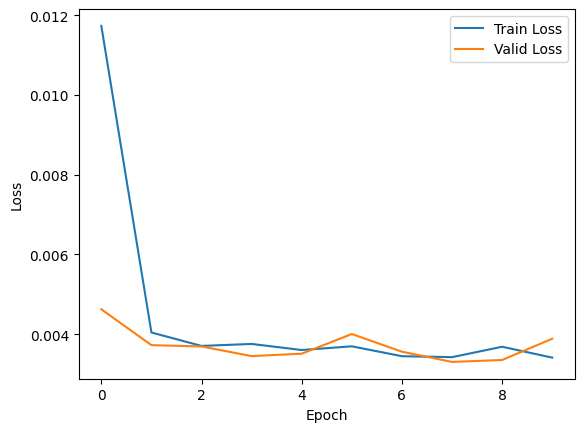

In [6]:
# Plot the learning curve
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

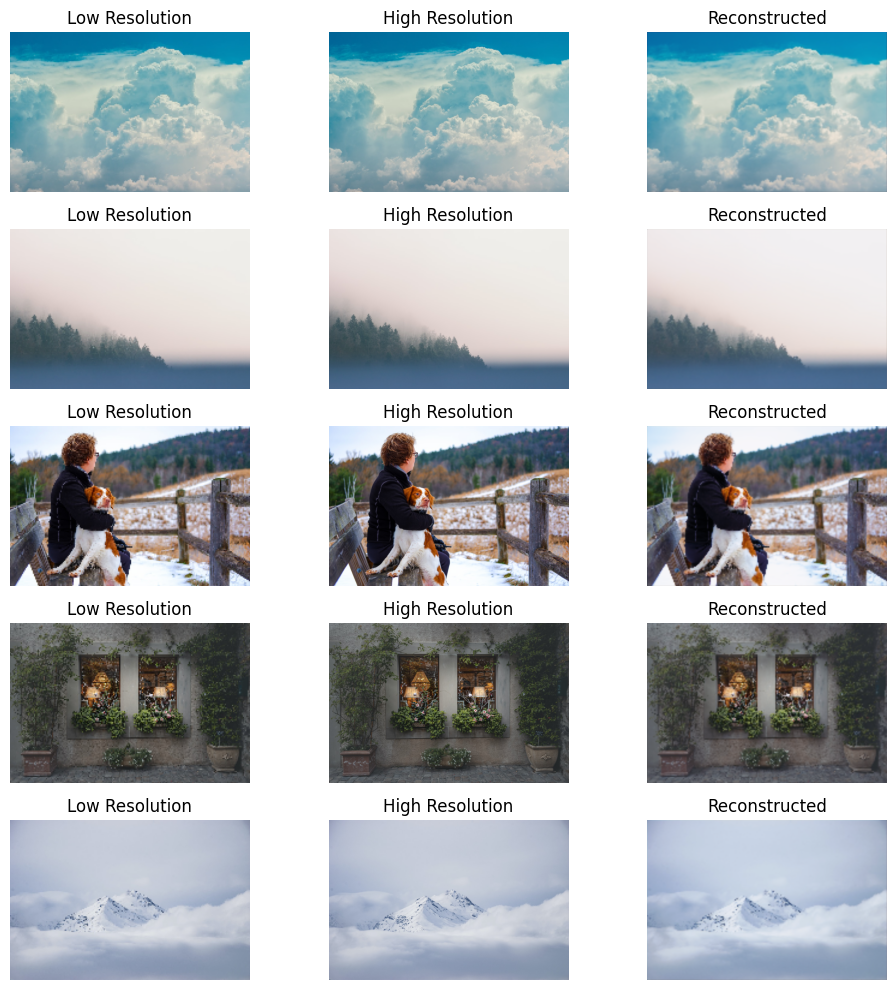

In [7]:

# Visualize low resolution images, their corresponding high resolution images, and reconstructed versions
model.eval()
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
with torch.no_grad():

    for batch_idx, (lowRes_images, highRes_images) in enumerate(test_loader):

        lowRes_images = lowRes_images.to(device)
        highRes_images = highRes_images.to(device)

        outputs = model(lowRes_images)

        # Denormalize and convert images to numpy arrays
        lowRes_images = lowRes_images.cpu().numpy().transpose(0, 2, 3, 1) * 255.0
        highRes_images = highRes_images.cpu().numpy().transpose(0, 2, 3, 1) * 255.0
        outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1) * 255.0

        # Plot images side by side
        fig, axes = plt.subplots(len(lowRes_images), 3, figsize=(10, 10))
        for i in range(len(lowRes_images)):

            axes[i, 0].imshow(lowRes_images[i].astype("uint8"))
            axes[i, 0].axis("off")
            axes[i, 0].set_title("Low Resolution")

            axes[i, 1].imshow(highRes_images[i].astype("uint8"))
            axes[i, 1].axis("off")
            axes[i, 1].set_title("High Resolution")

            axes[i, 2].imshow(outputs[i].astype("uint8"))
            axes[i, 2].axis("off")
            axes[i, 2].set_title("Reconstructed")

        plt.tight_layout()
        plt.show()
        break


In [8]:

# Setting the name of the datasets' folder
dataset_folder = 'image-super-resolution-from-unsplash/Image Super Resolution - Unsplash'

# List the contents of the dataset folder
print(os.listdir(dataset_folder))
current_directory = os.getcwd()

# Print the current working directory
print("Current Directory:", current_directory)
folder_name = 'image-super-resolution-from-unsplash/Image Super Resolution - Unsplash'
folder_path = os.path.join(current_directory, folder_name)
print(folder_path)


['high res', 'image_data.csv', 'low res']
Current Directory: /content
/content/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash


**This was one of the first cells that we made in order to find out the relative path of the datasets' folder.**